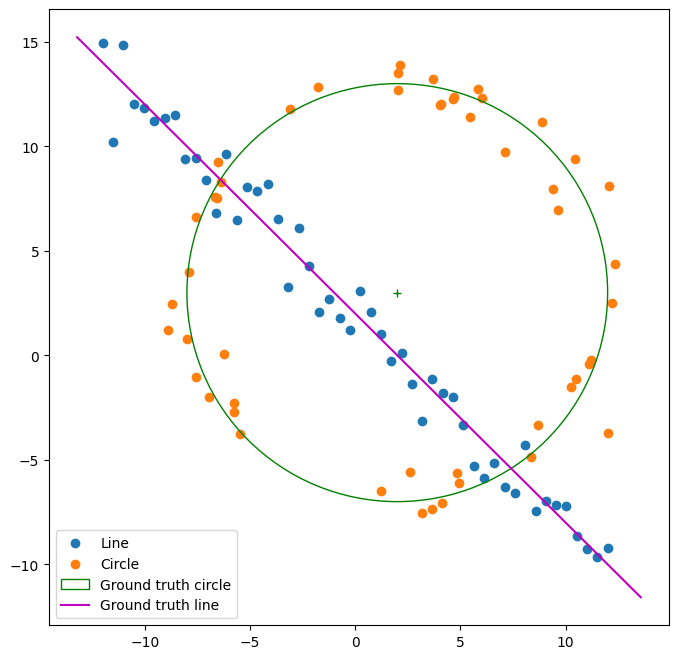

In [11]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
import math

# Set random seed (optional)
# np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()

# Optionally save the plot as a TikZ file
# tikzplotlib.save("plot.tex")

plt.show()



Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5082341912583727e-08
            Iterations: 12
            Function evaluations: 52
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.110012991860552e-08
            Iterations: 6
            Function evaluations: 26
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.890505213894796e-07
            Iterations: 17
            Function evaluations: 81
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.272437906000958e-08
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.019656509665222e-09
            Iterations: 8
            F

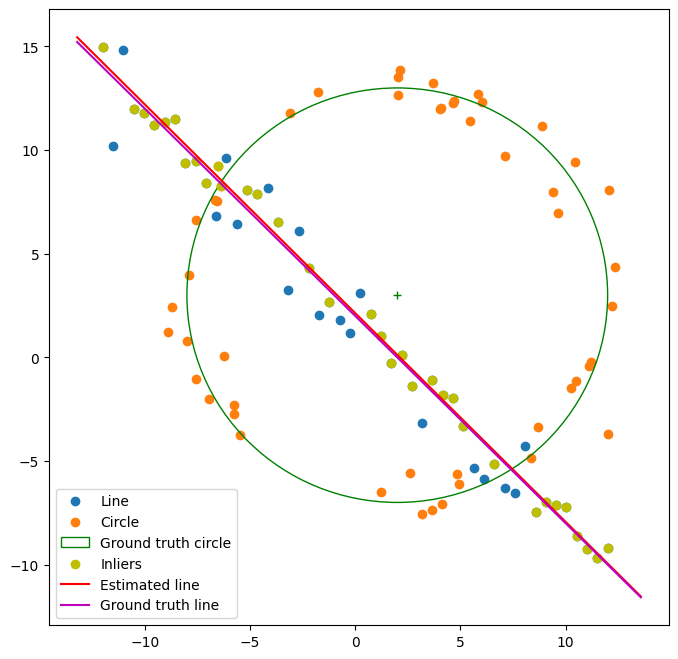

In [27]:
N=X.shape[0]
X_=X
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    # Return the line equation in the form ax + by = d
    return a, b, d

# RANSAC to fit a line
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

# Constraint
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

# Computing the consensus (inliers)
def consensus_line(X_, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t

# ...

def ransac_line(X, t, iter, in_t):
    n = X.shape[0]
    best_error = np.inf
    best_sample_line = []    # Three-point sample leading to the best model computation
    res_only_with_sample = [] # Result (a, b, d) only using the best sample
    best_inliers_line = []   #

    for i in range(iter):
        # Randomly sample 2 points
        indices = np.random.choice(n, 2, replace=False)
        x0 = [1, 1, 1]
        res = minimize(fun=line_tls, args=indices, x0=x0, tol=1e-6, constraints=cons, options={'disp': True})
        # Compute consensus
        inliers = consensus_line(X, res.x, t)  # Use res.x here instead of res.X
        # Compute number of inliers
        n_inliers = np.sum(inliers)
        if n_inliers > in_t:
            x0 = res.x
            res = minimize(fun=line_tls, args=inliers, x0=x0, tol=1e-6, constraints=cons, options={'disp': True})
            if res.fun < best_error:
                best_error = res.fun
                best_inliers_line = inliers
                best_a, best_b, best_d = res.x
                best_sample_line = indices
                print(indices)
                res_only_with_sample = x0

    return best_a, best_b, best_d, best_inliers_line, best_sample_line, res_only_with_sample



best_a, best_b, best_d, best_inliers_line, best_sample_line, res_only_with_sample = ransac_line(X, 0.7, 300, 0.33 * X.shape[0])


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')
ax.scatter(X[best_inliers_line,0],X[best_inliers_line,1], color='y', label='Inliers')
#ax.scatter(best_sample_line[0],best_sample_line[1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_a/best_b)*x_ + best_d/best_b
plt.plot(x_, y_est, color='r', label='Estimated line')
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 10.684403706976704
            Iterations: 44
            Function evaluations: 235
            Gradient evaluations: 44
Optimization terminated successfully    (Exit mode 0)
            Current function value: 72073.63411482133
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
[41  1 16]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 426.4856695847479
            Iterations: 19
            Function evaluations: 101
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6475.835352473123
            Iterations: 13
            Function evaluations: 70
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 151.86682601502866
            Iterations: 16
            Fu

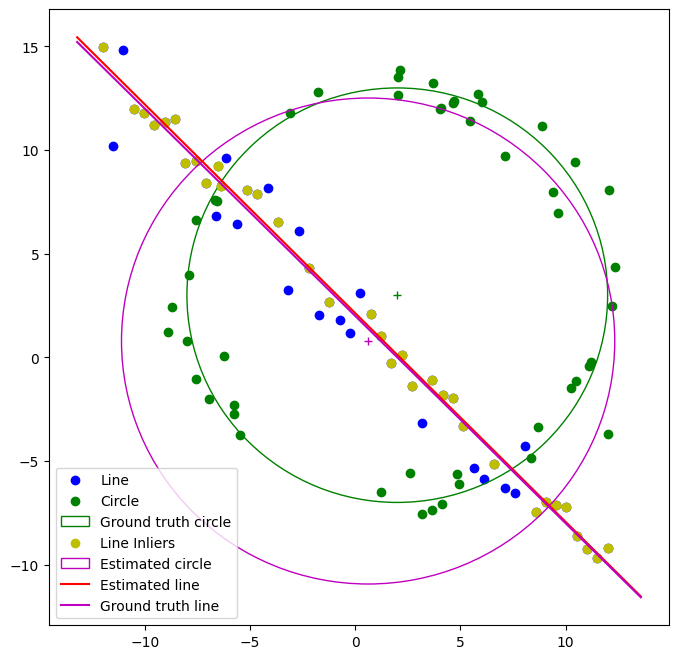

In [49]:
all_indices = np.arange(len(X))
remaining_indices = np.setdiff1d(all_indices, best_inliers_line)
remaining_points = X[remaining_indices]


def circle_consensus(data, model, threshold_inside, threshold_outside):
    # Calculate the Euclidean distance between data points and the circle's center
    center_x, center_y, radius = model
    distances = np.sqrt((data[:, 0] - center_x)**2 + (data[:, 1] - center_y)**2)
    
    # Check if the distances are within the threshold_inside for inside points
    inside_inliers = distances < threshold_inside
    
    # Check if the distances are within the threshold_outside for outside points
    outside_inliers = distances >= radius - threshold_outside
    
    # Combine the inside and outside inliers
    inliers = inside_inliers | outside_inliers
    
    return inliers



def circle_tls(x, indices, remaining_points):
    x_center, y_center, r = x[0], x[1], x[2]
    # Calculate the squared differences between the distances and the circle's radius
    squared_errors = (remaining_points[indices, 0] - x_center)**2 + (remaining_points[indices, 1] - y_center)**2 - r**2
    # Return the sum of squared errors
    return np.sum(np.square(squared_errors))


def ransac_circle(X, t, iter, in_t):
    n = X.shape[0]
    best_error = np.inf
    best_sample_circle = []    # Three-point sample leading to the best model computation
    res_only_with_sample = [] # Result (a, b, d) only using the best sample
    best_inliers_circle = []   #

    for i in range(iter):
        # Randomly sample 3 points
        indices = np.random.choice(n, 3, replace=False)
        x0 = [1, 1, 1]
        res = minimize(fun=circle_tls, args=(indices,X), x0=x0, tol=1e-6, constraints=cons, options={'disp': True})
        # Compute consensus
        inliers = circle_consensus(X, res.x, t, t)  # Use res.x here instead of res.X
        # Compute number of inliers
        n_inliers = np.sum(inliers)
        if n_inliers > in_t:
            x0 = res.x
            res = minimize(fun=circle_tls, args=(inliers,X), x0=x0, tol=1e-6, constraints=cons, options={'disp': True})
            if res.fun < best_error:
                best_error = res.fun
                best_inliers_circle = inliers
                best_x_center, best_y_center, best_r = res.x
                best_sample_circle = indices
                print(indices)
                res_only_with_sample = x0

    return best_x_center, best_y_center, best_r, best_inliers_circle, best_sample_circle, res_only_with_sample



best_x_center, best_y_center, best_r, best_inliers_circle, best_sample_circle, res_only_with_sample = ransac_circle(X_circ, 0.1, 1000, 0.3 * X.shape[0])
print(best_x_center, best_y_center, best_r)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for points
ax.scatter(X_line[:, 0], X_line[:, 1], color='b', label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color='g', label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

# Inliers for line
ax.scatter(X[best_inliers_line, 0], X[best_inliers_line, 1], color='y', label='Line Inliers')

# Inliers for circle
#ax.scatter(remaining_points[best_inliers_circle, 0], remaining_points[best_inliers_circle, 1], color='r', label='Circle Inliers')

# Estimated circle
circle_est = plt.Circle((best_x_center, best_y_center), best_r, color='m', fill=False, label='Estimated circle')

ax.add_patch(circle_est)
ax.plot(best_x_center, best_y_center, '+', color='m')

# Estimated line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_a / best_b) * x_ + best_d / best_b
plt.plot(x_, y_est, color='r', label='Estimated line')

# Ground truth line
plt.plot(x_, y_, color='m', label='Ground truth line')

# Legend
plt.legend()
plt.show()


In [38]:
import numpy as np
import cv2 as cv
# Create a list to store selected corner points
corner_points = []

def click_event(event, x, y, flags, param):
    global corner_points

    # If the left mouse button is clicked, record the coordinates
    if event == cv.EVENT_LBUTTONDOWN:
        corner_points.append((x, y))
        cv.circle(background_image, (x, y), 5, (0, 0, 255), -1)  # Draw a red circle at the clicked point
        cv.imshow('Image',background_image)

        # If all four corners are selected, stop capturing clicks
        if len(corner_points) == 4:
            cv.destroyAllWindows()

# Load your image here
img=cv.cvtColor(cv.imread('Screenshot 2023-09-30 205348.png'), cv.COLOR_BGR2RGB)

background_image = cv.imread('Screenshot 2023-09-30 205348.png')
#background_image_orig = cv.cvtColor(cv.imread('Screenshot 2023-09-30 185402.png'), cv.COLOR_BGR2RGB)
# Display the image and set a mouse callback function
cv.imshow('Image', background_image)
cv.setMouseCallback('Image', click_event)

# Wait for user interaction
cv.waitKey(0)

# Print the selected corner points
print("Selected Corner Points:")
for point in corner_points:
    print(point)

# Load the background image (architectural image)




Selected Corner Points:
(36, 52)
(34, 112)
(118, 116)
(121, 72)


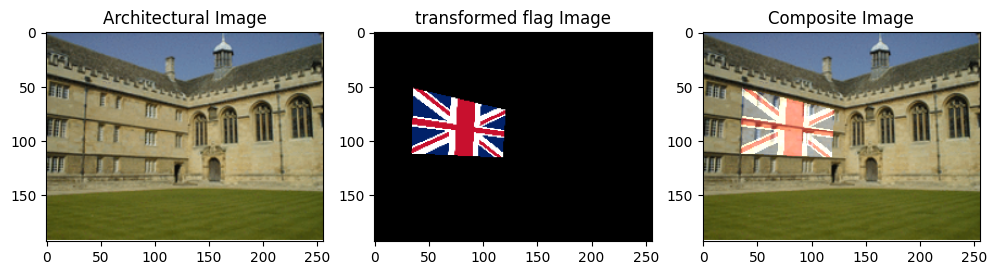

In [40]:

import matplotlib.pyplot as plt
img1=cv.imread('Screenshot 2023-09-30 205348.png')
# Load the architectural image and flag image

flag_image = cv.imread('Flag_of_the_United_Kingdom_(1-2).svg.png')

# Define the corresponding points in the architectural image and flag image
pts_architecture = np.array(corner_points, dtype=np.float32)
pts_flag = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)

# Calculate the homography matrix
homography_matrix, _ = cv.findHomography(pts_flag, pts_architecture)

# Warp the flag image
flag_warped = cv.warpPerspective(flag_image, homography_matrix, (background_image.shape[1], background_image.shape[0]))
flag=cv.cvtColor(flag_warped, cv.COLOR_BGR2RGB)
# Blend the images (alpha blending)
alpha = 0.5 # Adjust transparency as needed

composite_image = cv.addWeighted(img1, 1, flag_warped, alpha, 0, dst=background_image)
composite=cv.cvtColor(composite_image, cv.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Architectural Image')
plt.subplot(1, 3, 2)
plt.imshow(flag)
plt.title('transformed flag Image')
# Display the composite image
plt.subplot(1, 3, 3)
plt.imshow(composite)
plt.title('Composite Image')
plt.tight_layout()
plt.show()
